In [15]:
# PCA (10 marks):

# Run PCA on the fashion-MNIST dataset

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA

In [17]:
# Load the fashion-MNIST dataset
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [18]:
def sort_evals_descending(evals, evectors):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. This function
    also aligns the first two eigenvectors to be in first two quadrants if
    the data is 2D (remember that any eigenvector's direction can be inverted
    and it is still an eigenvector with the same eigenvalue). 
    """

    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0], 1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1], 1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]
    return evals, evectors

In [19]:
def pca(X):
    """
    Performs PCA on multivariate data.

    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

    Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : eigenvectors
    (numpy array of floats)   : corresponding eigenvalues

    """

    # Subtract the mean of X
    X_bar = X - np.mean(X, axis=0)
    # Calculate the sample covariance matrix
    cov_matrix = 1 / X.shape[0] * np.matmul(X_bar.T, X_bar)
    # Calculate the eigenvalues and eigenvectors
    evals, evectors = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues in descending order
    evals, evectors = sort_evals_descending(evals, evectors)
    # Project the data onto the new eigenvector basis
    score = np.matmul(X, evectors)

    return score, evectors, evals

In [31]:
# Call pca on data
score, evectors, evals = pca(X_train)
print(X_train.shape)
print(score[0:2,:].shape)

(60000, 784)
(2, 784)


In [21]:
# Gaussian mixture modelling (15 marks):

# Use a Gaussian Mixture Model (GMM) to do (soft) clustering using the first two components from the PCA analysis. 
# Make the GMM a mixture of 10 gaussians

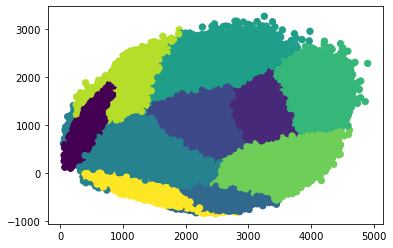

In [42]:
from sklearn import mixture
first_two_features = score[:,:2]
model = mixture.GaussianMixture(n_components=10, covariance_type='full').fit(first_two_features)
labels = model.predict(first_two_features)
plt.scatter(first_two_features[:, 0], first_two_features[:, 1], c=labels, s=40, cmap='viridis');